## BTC Option Volatility Time Series

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
plt.rcParams["figure.figsize"] = (16, 10)

### Generate underlying index price time series

In [4]:
btc_index_dbit_df = pd.read_csv('deribit_btc_usd_index_19-05-01_20-05-31_5min.csv')
btc_index_dbit_df['Date and Time'] = pd.to_datetime(btc_index_dbit_df['Date and Time'], format='%Y-%m-%d %H:%M:%S')
btc_index_dbit_df = btc_index_dbit_df.set_index('Date and Time')
btc_index_dbit_df

,Price
Date and Time,
2019-05-01 00:00:00+00:00,5269.46
2019-05-01 00:05:00+00:00,5268.33
2019-05-01 00:10:00+00:00,5272.10
2019-05-01 00:15:00+00:00,5277.00
2019-05-01 00:20:00+00:00,5289.70
...,...
2020-05-31 23:35:00+00:00,9433.96
2020-05-31 23:40:00+00:00,9410.57
2020-05-31 23:45:00+00:00,9418.37


<AxesSubplot:xlabel='Date and Time'>

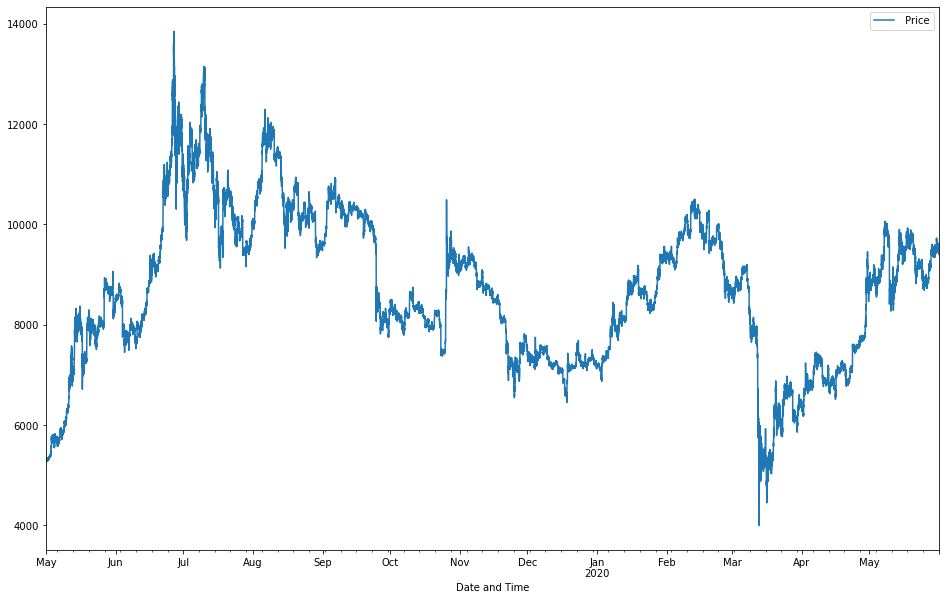

In [5]:
btc_index_dbit_df.plot()

### Function to load required orderbook data

In [11]:
import glob
import os

# Shorthand for dictionary lookup
co = 'C' # Call option
po = 'P' # Put option

csv_path = '/home/fp361/cloud-mounts/deribit_orderbook_data/'

In [53]:
def read_orderbook_data(csv_paths, expiry, coinapi=False, data_dict=dict()):
    if expiry not in data_dict:
        data_dict[expiry] = dict()
    else:
        # Already read
        return data_dict
    
    near_next_csv = list()
    for path in csv_paths:
        near_next_csv += glob.glob(path + f'BTC-{expiry}-*-*.csv')

    #if len(near_next_csv) == 0:
    #    raise ValueError(f'{expiry} data unavailable!')
        
    print(f'Reading {expiry} data from disk...')

    for file_path in near_next_csv:
        instrument = os.path.basename(file_path).split('-')
        exp, strike, cp = instrument[1], int(instrument[2]), instrument[3].split('.')[0]  

        if strike not in data_dict[exp]:
            data_dict[exp][strike] = dict()
        try:    
            df = pd.read_csv(file_path).filter(['timestamp', 'best_bid_price', 'best_ask_price'])
            df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms', errors='coerce')
            df = df.set_index('timestamp').drop_duplicates()
            if coinapi:
                df.loc[instrument_start_end[exp]['start']] = [np.nan, np.nan]
                df.loc[instrument_start_end[exp]['end']] = [np.nan, np.nan]
                df = df.sort_index()
                df_resampled = df.resample('5min').ffill().fillna(method='bfill')#s.dropna()
            else:
                df_resampled = df.resample('5min').last().dropna()
        except Exception as e:
            print('ERROR', file_path, e)
            
        data_dict[exp][strike][cp] = df_resampled
        
    return data_dict 

Test: This call should return a five-minute resampled time-series dataframe of best bids and asks for BTC-3APR20-6750-C.

In [54]:
test = read_orderbook_data([csv_path], '3APR20')['3APR20'][6750][co]
test

Reading 3APR20 data from disk...


,best_bid_price,best_ask_price
timestamp,,
2020-03-29 17:50:00,0.0090,0.011
2020-03-29 17:55:00,0.0090,0.011
2020-03-29 18:00:00,0.0090,0.011
2020-03-29 18:05:00,0.0090,0.011
2020-03-29 18:10:00,0.0090,0.011
...,...,...
2020-04-03 07:40:00,0.0190,0.025
2020-04-03 07:45:00,0.0190,0.031
2020-04-03 07:50:00,0.0220,0.030


## Volatility Indices

### Preparing data for vxbt_calc

For testing, choose random time.

In [71]:
now = pd.to_datetime('2020-04-20 00:00:00')

Import our *vxbt_calc* module.

In [72]:
from vxbt_calc import vxbt_calc

In [73]:
near_expiry, next_expiry, near_datetime, next_datetime = vxbt_calc.get_near_next_terms(now)
csv_path2 = '/home/fp361/bitfear/deribit-orderbook-scraper/scraped_data/'

orderbook_data = dict()
orderbook_data = read_orderbook_data([csv_path, csv_path2], near_expiry, data_dict=orderbook_data)
orderbook_data = read_orderbook_data([csv_path, csv_path2], next_expiry, data_dict=orderbook_data)

Reading 24APR20 data from disk...
ERROR /home/fp361/cloud-mounts/deribit_orderbook_data/BTC-24APR20-12000-C.csv index must be monotonic increasing or decreasing
ERROR /home/fp361/cloud-mounts/deribit_orderbook_data/BTC-24APR20-4500-C.csv index must be monotonic increasing or decreasing
Reading 1MAY20 data from disk...


In [74]:
print(near_expiry, next_expiry)
print(orderbook_data.keys())

24APR20 1MAY20
dict_keys(['24APR20', '1MAY20'])


The xvbt_calc module requires four dataframes - near_calls_df, near_puts_df, next_calls_df, next_puts_df - to perform an offline index calculation.

In [75]:
def build_dataframes(time, near_expiry, next_expiry, data_dict):
    near_calls = dict()
    near_puts = dict()
    next_calls = dict()
    next_puts = dict()

    index_price = btc_index_dbit_df[' Price'].loc[time]
    
    for strike in data_dict[near_expiry]:
        try:
            near_calls[strike] = data_dict[near_expiry][strike]['C'].loc[time].astype(float) * index_price
        except KeyError:
            #print(f'Error {strike} near calls')
            pass

        try:
            near_puts[strike] = data_dict[near_expiry][strike]['P'].loc[time].astype(float) * index_price
        except KeyError:
            #print(f'Error {strike} near puts')
            pass
    
    for strike in data_dict[next_expiry]:
        try:
            next_calls[strike] = data_dict[next_expiry][strike]['C'].loc[time].astype(float) * index_price
        except KeyError:
            #print(f'Error {strike} next calls')
            pass

        try:
            next_puts[strike] = data_dict[next_expiry][strike]['P'].loc[time].astype(float) * index_price
        except KeyError:
            #print(f'Error {strike} next puts')
            pass
        
    near_calls_df = pd.DataFrame.from_dict(near_calls, orient='index').sort_index().replace(0, np.nan).rename(columns={'best_bid_price': 'best_bid', 'best_ask_price': 'best_ask'})
    near_puts_df = pd.DataFrame.from_dict(near_puts, orient='index').sort_index().replace(0, np.nan).rename(columns={'best_bid_price': 'best_bid', 'best_ask_price': 'best_ask'})
    next_calls_df = pd.DataFrame.from_dict(next_calls, orient='index').sort_index().replace(0, np.nan).rename(columns={'best_bid_price': 'best_bid', 'best_ask_price': 'best_ask'})
    next_puts_df = pd.DataFrame.from_dict(next_puts, orient='index').sort_index().replace(0, np.nan).rename(columns={'best_bid_price': 'best_bid', 'best_ask_price': 'best_ask'})
    
    return near_calls_df, near_puts_df, next_calls_df, next_puts_df

In [76]:
dfs = build_dataframes(now, near_expiry, next_expiry, orderbook_data)
dfs

(       best_bid    best_ask
 6250  805.69226  1087.32805
 6750  449.19126   499.10140
 7250  128.34036   149.73042
 7750   39.21511    42.78012
 8250   14.26004    24.95507
 8500   10.69503    17.82505,
        best_bid    best_ask
 6250   32.08509    35.65010
 6750   67.73519    71.30020
 7250  267.37575   292.33082
 7750  655.96184   709.43699
 8250    3.56501  4648.77304
 8500   21.39006  4791.37344,
         best_bid    best_ask
 5250  1743.28989  2049.88075
 5500  1490.17418  1818.15510
 5750  1322.61871  1586.42945
 6000  1180.01831  1233.49346
 6250   909.07755   987.50777
 6500   688.04693   773.60717
 6750   502.66641   581.09663
 7000   395.71611   434.93122
 7250   249.55070   253.11571
 7500   174.68549   181.81551
 7750   117.64533   142.60040
 8000    71.30020    92.69026
 8250    53.47515    74.86521
 8500    35.65010    57.04016
 8750    28.52008    46.34513
 9000    17.82505    35.65010,
         best_bid    best_ask
 5250    17.82505    32.08509
 5500    32.08509    

In [77]:
vxbt_calc.get_indices(live=False, time=now, dfs=dfs)

(72.84395092670388, 73.78612644232778, 0.01054329057880957)

### Build the time series

Calculate VXBT value at each five minute interval during required time period.

In [64]:
import datetime

In [68]:
orderbook_data = dict()

now = pd.to_datetime('2020-04-01 00:00:00')
end = pd.to_datetime('2020-05-01 00:00:00')

indices_df = pd.DataFrame(columns=['timestamp', 'vxbt', 'gvxbt', 'avxbt'])

while now < end:
    near_expiry, next_expiry, near_datetime, next_datetime = vxbt_calc.get_near_next_terms(now)
    
    orderbook_data = read_orderbook_data([csv_path, csv_path2], near_expiry, data_dict=orderbook_data)
    orderbook_data = read_orderbook_data([csv_path, csv_path2], next_expiry, data_dict=orderbook_data)
    
    if not orderbook_data[near_expiry] or not orderbook_data[next_expiry]:
        print(f'WARNING: Insufficient data at {now}')
        now += datetime.timedelta(minutes=5)
        continue

    try:
        dfs = build_dataframes(now, near_expiry, next_expiry, orderbook_data)
        VXBT, GVXBT, AVXBT = vxbt_calc.get_indices(live=False, time=now, dfs=dfs)
        
        indices_df = indices_df.append({'timestamp': now, 'vxbt': VXBT, 'gvxbt': GVXBT, 'avxbt': AVXBT}, ignore_index=True)
    #except KeyError:
    #    print(f'WARNING: Insufficient data at {now}')
    except Exception as e:
        print(f'WARNING: Unhandled error at {now}')
        print(e)
    
    now += datetime.timedelta(minutes=5)


Reading 3APR20 data from disk...
Reading 10APR20 data from disk...
Reading 17APR20 data from disk...
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bi

'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'

'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'

'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'

'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'

'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'

'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'

'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'

'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'

'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'

'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'

'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'

'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
Reading 24APR20 data from disk...
ERROR /home/fp361/cloud-mounts/deribit_orderbook_data/BTC-24APR20-12000-C.csv index must be monotonic increasing or decreasing
ERROR /home/fp361/cloud-mounts/deribit_orderbook_data/BTC-24APR20-4500-C.csv index must be monotonic increasing or decreasing
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid

'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'

'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'

'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'

'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'

'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'

'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'

'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'

'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'

'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'

'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'

'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'

'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'

'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'
'best_bid'

In [69]:
indices_df = indices_df.set_index('timestamp')
indices_df

,vxbt,gvxbt,avxbt
timestamp,,,
2020-04-01 00:00:00,93.824307,89.261309,0.013554
2020-04-01 00:05:00,93.893394,89.307673,0.013561
2020-04-01 00:10:00,93.857000,89.214182,0.013547
2020-04-01 00:15:00,92.888188,88.120698,0.013364
2020-04-01 00:20:00,92.611490,88.833339,0.014188
...,...,...,...
2020-04-30 23:35:00,88.232624,84.125691,0.009523
2020-04-30 23:40:00,88.082736,83.949366,0.009503
2020-04-30 23:45:00,88.215222,84.056193,0.009518


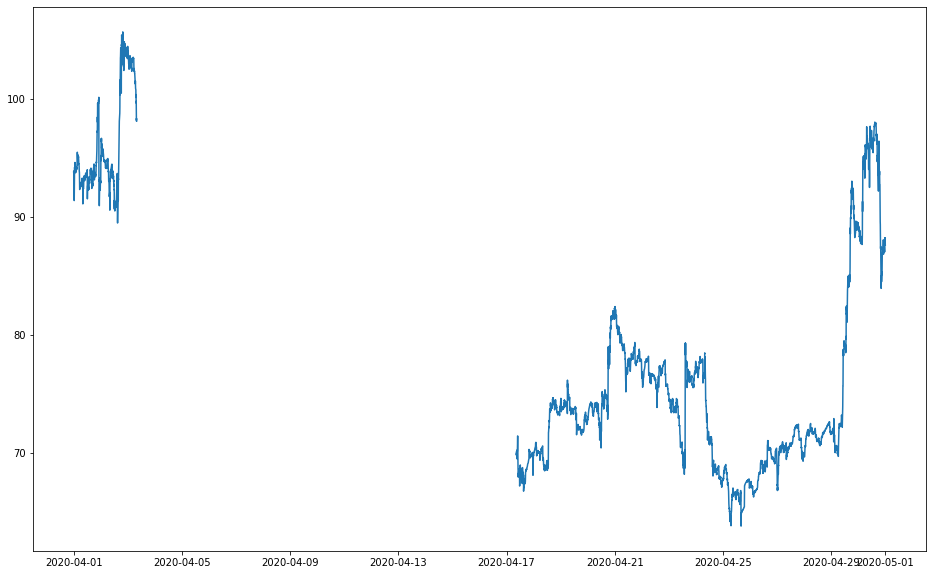

In [70]:
plt.plot(indices_df['vxbt'])

In [ ]:
fig, ax =  plt.subplots(2,2)

plot_start = '2020-04-17 00:00:00'

ax[0][0].plot(index_prices_5min[plot_start:], color='blue')
ax[0][0].set_xlabel('Time')
ax[0][0].set_ylabel('Deribit BTC Index Price (US $)')
ax[0][0].tick_params(labelrotation=45)

ax[0][1].plot(indices_df['vxbt'][plot_start:])
ax[0][1].set_xlabel('Time')
ax[0][1].set_ylabel('VXBT')
ax[0][1].tick_params(labelrotation=45)

ax[1][0].plot(indices_df['gvxbt'][plot_start:])
ax[1][0].set_xlabel('Time')
ax[1][0].set_ylabel('GVXBT')
ax[1][0].tick_params(labelrotation=45)

ax[1][1].plot(indices_df['avxbt'][plot_start:])
ax[1][1].set_xlabel('Time')
ax[1][1].set_ylabel('AVXBT')
ax[1][1].tick_params(labelrotation=45)

fig.suptitle(f'Volatility Time Series ({plot_start}-)')

### Volatility index time series from live calculator

In [ ]:
live_df = pd.read_csv('live_indices.csv').drop(['index_usd'], axis=1)
live_df['timestamp'] = pd.to_datetime(live_df['timestamp'])
live_df = live_df.set_index('timestamp')
live_df

In [ ]:
both_df = pd.concat([indices_df, live_df.loc['2020-04-28 17:42:00':]])
both_df

In [ ]:
fig, ax =  plt.subplots(2,2)

#plot_start = live_df.index[0]

ax[0][0].plot(index_prices_5min[plot_start:], color='blue')
ax[0][0].set_xlabel('Time')
ax[0][0].set_ylabel('Deribit BTC Index Price (US $)')
ax[0][0].tick_params(labelrotation=45)

ax[0][1].plot(both_df['vxbt'][plot_start:])
ax[0][1].set_xlabel('Time')
ax[0][1].set_ylabel('VXBT')
ax[0][1].tick_params(labelrotation=45)

ax[1][0].plot(both_df['gvxbt'][plot_start:])
ax[1][0].set_xlabel('Time')
ax[1][0].set_ylabel('GVXBT')
ax[1][0].tick_params(labelrotation=45)

ax[1][1].plot(both_df['avxbt'][plot_start:])
ax[1][1].set_xlabel('Time')
ax[1][1].set_ylabel('AVXBT')
ax[1][1].tick_params(labelrotation=45)

fig.suptitle(f'Volatility Time Series ({plot_start}-)')

### Export for use in ARIMA/regression models

In [ ]:
both_df[plot_start:].to_csv('volatility_data.csv')

***

## CoinAPI

In [ ]:
import requests
import json

In [ ]:
url_syms = 'https://rest.coinapi.io/v1/symbols?filter_symbol_id=DERIBIT_OPT_BTC_USD_{}'
url_quotes = 'https://rest.coinapi.io/v1/quotes/{}/history?time_start={}&time_end={}&limit=100000'

headers = {'X-CoinAPI-Key' : 'B0F2DAAE-D649-4C30-AB64-F7943DC7ED81'}
#headers = {'X-CoinAPI-Key' : '6E38A06D-403C-4B71-9011-8CCAB6EC2C19'}
#headers = {'X-CoinAPI-Key' : '0320B776-8C7B-4346-B745-584FA43A67BB'}

capi_data_path = '/home/fp361/bitfear/vix-implementation/coinapi/'

In [ ]:
instrument_start_end = dict()

start_c = pd.to_datetime('2019-05-01 00:00:00')
end_c = pd.to_datetime('2020-05-01 00:00:00')

now_c = start_c

while now_c <= end_c:
    for expiry in vxbt_calc.get_near_next_terms(now_c)[:2]:
        if expiry in instrument_start_end:
            instrument_start_end[expiry]['end'] = now_c + datetime.timedelta(minutes=15)
        else:
            instrument_start_end[expiry] = {'start': now_c - datetime.timedelta(hours=1, minutes=15), 'end': ''}
            
    now_c += datetime.timedelta(hours=1)

In [ ]:
instrument_start_end

In [ ]:
def handle_coinapi(url, request_headers):
    response = requests.get(url, headers=request_headers)
    headers = response.headers
    content = json.loads(response.content.decode())

    try:
        limit_reached = int(headers['x-ratelimit-remaining']) - int(headers['x-ratelimit-request-cost']) < 5
    except KeyError:
        print(f'Response headers {headers}')
        print(f'Response content {content}')
        raise
    print(response.headers)
    return content, limit_reached

In [ ]:
limit_reached = False

In [ ]:
completed_instruments = [file_path.split('/')[-1] for file_path in glob.glob(capi_data_path + '*.csv')]
completed_instruments

In [ ]:
limit_reached = False

for expiry in instrument_start_end:
    if not limit_reached:
        start_time_string = instrument_start_end[expiry]['start'].isoformat() + 'Z'
        end_time_string = instrument_start_end[expiry]['end'].isoformat() + 'Z'
        expiry_string = datetime.datetime.strftime(instrument_start_end[expiry]['end'], '%y%m%d')
        
        url = url_syms.format(expiry_string)
        content, limit_reached = handle_coinapi(url, headers)

        instruments = [instrument['symbol_id'] for instrument in content]
        
        if limit_reached:
            print(f'CoinAPI limit reached after getting {expiry} instruments list.')
            break

        for instrument in content:
            name = instrument['symbol_id']
            strike, cp = name.split('_')[5:]
            fname = f'BTC-{expiry}-{strike}-{cp}.csv'
            
            if fname not in completed_instruments:
                url = url_quotes.format(name, start_time_string, end_time_string)                
                content, limit_reached = handle_coinapi(url, headers)
                
                if limit_reached or not content:
                    break

                df = pd.DataFrame.from_dict(content).drop(['symbol_id', 'time_coinapi', 'ask_size', 'bid_size'], axis=1).rename({'time_exchange': 'timestamp', 'ask_price':  'best_ask_price', 'bid_price': 'best_bid_price'}, axis=1).replace(-1, 0)
                df['timestamp'] = pd.to_datetime(df['timestamp']).values.astype(np.int64) // 10 ** 6
                df.to_csv(f'{capi_data_path}{fname}', index=False)

                last = name
                print(f'Successfully created {fname}.')
            
            else:
                print(f'Skipping {name} as {fname} already exists.')
                
    else:
        print(f'Limit reached after getting {last}.')
        break

In [ ]:
test_c = read_orderbook_data([capi_data_path], '17MAY19', coinapi=True)['17MAY19'][6000][po]
#test_c.loc[instrument_start_end['3MAY19']['start']] = [np.nan, np.nan]
#test_c.sort_index().resample('5min').last().fillna(method='ffill').fillna(method='bfill').dropna()
test_c

In [ ]:
now_c = start_c
end_c = end_c

In [ ]:
near_expiry, next_expiry, near_datetime, next_datetime = vxbt_calc.get_near_next_terms(now)

#orderbook_data = dict()
#orderbook_data = read_orderbook_data([capi_data_path], near_expiry, orderbook_data)
#orderbook_data = read_orderbook_data([capi_data_path], next_expiry, orderbook_data)

In [ ]:
capi_orderbook_data = dict()

capi_indices_df = pd.DataFrame(columns=['timestamp', 'vxbt', 'gvxbt', 'avxbt'])
results = {}

while now_c < end_c:
    near_expiry, next_expiry, near_datetime, next_datetime = vxbt_calc.get_near_next_terms(now_c)
    
    capi_orderbook_data = read_orderbook_data([capi_data_path], near_expiry, coinapi=True, data_dict=capi_orderbook_data)
    capi_orderbook_data = read_orderbook_data([capi_data_path], next_expiry, coinapi=True, data_dict=capi_orderbook_data)
    
    if not capi_orderbook_data[near_expiry] or not capi_orderbook_data[next_expiry]:
        print(f'WARNING: Insufficient data at {now_c}')
        now_c += datetime.timedelta(minutes=5)
        continue

    try:
        dfs = build_dataframes(now_c, near_expiry, next_expiry, capi_orderbook_data)
        VXBT, GVXBT, AVXBT = vxbt_calc.get_indices(live=False, time=now_c, dfs=dfs)
            
        #capi_indices_df = capi_indices_df.append({'timestamp': now_c, 'vxbt': VXBT, 'gvxbt': GVXBT, 'avxbt': AVXBT}, ignore_index=True)
        results['timestamp'] = [VXBT, GVXBT, AVXBT]
    except KeyError as e:
        print(f'WARNING: Insufficient data at {now_c}, {repr(e)}')
    except Exception as e:
        print(f'WARNING: Unhandled error at {now_c}')
        print(repr(e))
    
    now_c += datetime.timedelta(minutes=5)

In [ ]:
now_c = '2019-05-03 07:15:00'
VXBT, GVXBT, AVXBT = vxbt_calc.get_indices(live=False, time=now_c, dfs=dfs)
VXBT

In [ ]:
capi_indices_df.set_index('timestamp')['vxbt'].plot()

In [ ]:
df = pd.read_csv('volatility_data.csv')
df['timestamp'] = pd.to_datetime(df['timestamp'])
df = df.set_index('timestamp')
df

In [ ]:
df2 = pd.read_csv('live_indices.csv')
df2['timestamp'] = pd.to_datetime(df2['timestamp'])
df2 = df2.set_index('timestamp')
df2

In [ ]:
v_df = pd.concat([df.loc[:'2020-04-28 17:41:00'], df2.loc['2020-04-28 17:42:00':]])
v_df

In [ ]:
v_df.to_csv('volatility_dataset.csv')